# AR Sliding Window

In [150]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.api import OLS, add_constant
from scipy.stats import shapiro, anderson
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
import pmdarima as pm
from itertools import product
from itertools import product
import re
from tqdm import tqdm
from IPython.display import display, Markdown
from joblib import Parallel, delayed
from matplotlib.dates import DateFormatter

In [151]:
import pmdarima
import numpy
import scipy

print("pmdarima:", pmdarima.__version__)
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)

pmdarima: 2.0.4
numpy: 1.26.0
scipy: 1.15.3


In [152]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet with Original Data.xlsx')
# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

In [153]:
df_exog = pd.read_excel('data/All Exogenous Variables.xlsx')
# Ensure date is datetime and set index
df_exog['Month'] = pd.to_datetime(df_exog['Month'])
df_exog.set_index('Month', inplace=True)
df_exog.index = pd.date_range(start=df_exog.index[0], periods=len(df_exog), freq='MS')
df_exog.columns = df_exog.columns.str.strip()

In [154]:
warnings.filterwarnings(
    "ignore",
    message=re.escape("'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8."),
    category=FutureWarning,
    module=r"sklearn\.utils\.deprecation"
)

In [155]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC']

In [156]:
windows = [
    ('2019-07-01', '2022-02-01'),
    ('2022-04-01', '2025-01-01'),
    ('2020-06-01', '2025-01-01')
]

In [157]:
def check_model_assumptions(y_train, X_train, model_residuals):
    model_residuals = model_residuals[4:]
    assumptions = {}

    if X_train.shape[1] > 0:
        # Add constant
        X_const = add_constant(X_train)

        # Only run BP if enough columns
        if X_const.shape[1] >= 2:
            ols_model = OLS(y_train, X_const).fit()
            bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols_model.resid, X_const)
            assumptions["Breusch-Pagan p"] = bp_pvalue
        else:
            assumptions["Breusch-Pagan p"] = np.nan
    else:
        assumptions["Breusch-Pagan p"] = np.nan

    # Normality
    shapiro_stat, shapiro_p = shapiro(model_residuals)
    ad_result = anderson(model_residuals)
    assumptions["Shapiro p"] = shapiro_p
    assumptions["Anderson stat"] = ad_result.statistic
    assumptions["Anderson crit"] = list(zip(ad_result.significance_level, ad_result.critical_values))

    # Residual mean
    assumptions["Mean resid"] = model_residuals.mean()

    # Autocorrelation
    assumptions["Durbin-Watson"] = durbin_watson(model_residuals)

    return assumptions


In [158]:
def calc_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test):
    # Training R^2
    # Exclude first 4 values from train R² calculation
    y_true_train_trimmed = y_true_train[4:]
    y_pred_train_trimmed = y_pred_train[4:]
    r2 = r2_score(y_true_train_trimmed, y_pred_train_trimmed)

    # Test errors
    mae = mean_absolute_error(y_true_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    # Handle possible zeros in true values for MAPE
    y_true_test_nonzero = y_true_test.replace(0, np.nan).dropna()
    y_pred_test_aligned = y_pred_test[y_true_test_nonzero.index]
    mape = np.mean(np.abs((y_true_test_nonzero - y_pred_test_aligned) / y_true_test_nonzero)) * 100

    return {'R2_train': r2, 'MAE_test': mae, 'RMSE_test': rmse, 'MAPE_test': mape}

In [ ]:
def run_model(macro, exog, window, diff, show = False):
    start_date, end_date = pd.to_datetime(window[0]), pd.to_datetime(window[1])

    # Select y series and exog window
    y = df[macro].loc[start_date:end_date].dropna().asfreq('MS')
    exog = df_exog[exog].dropna().asfreq('MS')
    exog_window = exog.loc[start_date:end_date].dropna().asfreq('MS')

    # Align
    y, exog_window = y.align(exog_window, join='inner')

    # Train-test split
    split_idx = int(len(y) * 0.8)
    train, test = y[:split_idx], y[split_idx:]
    exog_train, exog_test = exog_window[:split_idx], exog_window[split_idx:]

    # AR model
    model_ar = pm.auto_arima(
        train,
        start_p=1, start_q=0, start_P=0, start_Q=0,
        max_p=5, max_q=5, max_P=2, max_Q=2, D=1, d = diff,
        m=3,
        seasonal=True,
        stepwise=True,
        suppress_warnings=True
    )
    forecast_ar, conf_int_ar = model_ar.predict(n_periods=len(test), return_conf_int=True)
    fitted_ar = pd.Series(model_ar.predict_in_sample(), index=train.index)

    # ARX model
    model_arx = pm.auto_arima(
        train,
        X=exog_train,
        seasonal=True,
        m=3,
        start_p=1, start_q=0, D = 1, d = diff,
        max_p=3, max_q=5,
        max_P=2, max_Q=2,
        stepwise=True,
        trace=False,
        suppress_warnings=True
    )
    forecast_arx, conf_int_arx = model_arx.predict( n_periods=len(test), X=exog_test, return_conf_int=True)
    fitted_arx = pd.Series(model_arx.predict_in_sample(X=exog_train), index=train.index)

    # Print orders
    print("AR Order:", model_ar.order, "Seasonal:", model_ar.seasonal_order)
    print("ARX Order:", model_arx.order, "Seasonal:", model_arx.seasonal_order)

    print("\n=== AR Model Summary ===")
    print(model_ar.arima_res_.summary())
    print("\n=== ARX Model Summary ===")
    print(model_arx.arima_res_.summary())

    # Calculate metrics
    metrics_ar = calc_metrics(train, fitted_ar, test, forecast_ar)
    metrics_arx = calc_metrics(train, fitted_arx, test, forecast_arx)

    if show:
        sns.set(style="whitegrid")
        colors = {'Actual': 'black', 'AR Forecast': '#1f77b4', 'ARX Forecast': '#d62728'}
        ci_colors = {'AR CI': '#aec7e8', 'ARX CI': '#ff9896'}
        marker_styles = {'Actual': 'o', 'AR Forecast': 'x', 'ARX Forecast': '^'}

        # Common date formatter for x-axis
        date_fmt = DateFormatter('%Y-%m')

        # Plot 1: Full window with both forecasts
        exog_str = ', '.join(exog)
        arx_label = f'ARX Forecast (with {exog_str})'
        plt.figure(figsize=(12, 6))
        plt.plot(y.index, y, label='Actual', color=colors['Actual'])
        plt.plot(test.index, forecast_ar, label='AR Forecast', linestyle='--', color=colors['AR Forecast'])
        plt.plot(test.index, forecast_arx, label=arx_label, linestyle='--', color=colors['ARX Forecast'])
        plt.fill_between(test.index, conf_int_ar[:, 0], conf_int_ar[:, 1],
                        color=ci_colors['AR CI'], alpha=0.3, label='AR 95% CI')
        plt.fill_between(test.index, conf_int_arx[:, 0], conf_int_arx[:, 1],
                        color=ci_colors['ARX CI'], alpha=0.3, label='ARX 95% CI')
        plt.axvline(x=test.index[0], color='gray', linestyle=':', label='Train/Test Split')
        plt.title(f'{macro} Forecasts With and Without Crypto Volatility ({exog_str})', fontsize=16, weight='bold')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(macro, fontsize=14)
        plt.gca().xaxis.set_major_formatter(date_fmt)
        plt.xticks(rotation=45)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.savefig(f'{macro}_forecast_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 2: Zoomed in on test period
        plt.figure(figsize=(12, 6))
        plt.plot(test.index, test, label='Actual', marker=marker_styles['Actual'],
                color=colors['Actual'], linestyle='-', linewidth=1.5)
        plt.plot(test.index, forecast_ar, label='AR Forecast', linestyle='--',
                marker=marker_styles['AR Forecast'], color=colors['AR Forecast'], linewidth=1.5)
        plt.plot(test.index, forecast_arx, label='ARX Forecast', linestyle='--',
                marker=marker_styles['ARX Forecast'], color=colors['ARX Forecast'], linewidth=1.5)
        plt.fill_between(test.index, conf_int_ar[:, 0], conf_int_ar[:, 1],
                        color=ci_colors['AR CI'], alpha=0.3, label='AR 95% CI')
        plt.fill_between(test.index, conf_int_arx[:, 0], conf_int_arx[:, 1],
                        color=ci_colors['ARX CI'], alpha=0.3, label='ARX 95% CI')
        plt.title(f'Test Period Forecast Comparison: {macro}', fontsize=16, weight='bold')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(macro, fontsize=14)
        plt.gca().xaxis.set_major_formatter(date_fmt)
        plt.xticks(rotation=45)
        plt.legend(loc='best',fontsize=12)
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()


    # Check model assumption
    # Get residuals (actual - fitted)
    resid_ar = train - fitted_ar
    resid_arx = train - fitted_arx

    # Run assumption checks
    assumptions_ar = check_model_assumptions(train, pd.DataFrame(index=train.index), resid_ar)
    assumptions_arx = check_model_assumptions(train, exog_train, resid_arx)

    # Combine and display metrics
    metrics_df = pd.DataFrame([metrics_ar, metrics_arx], index=['AR', 'ARX'])
    assumptions_df = pd.DataFrame([assumptions_ar, assumptions_arx], index=['AR', 'ARX'])
    if show:
        display(Markdown("### Model Forecast Accuracy Metrics"))
        display(metrics_df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
        display(Markdown("### Model Assumption Check"))
        display(assumptions_df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

    # Extract exogenous p-values from ARX model
    exog_pvals = model_arx.arima_res_.pvalues
    exog_pvals = exog_pvals[exog_train.columns.intersection(exog_pvals.index)]

    return {
        'metrics_ar': metrics_ar,
        'metrics_arx': metrics_arx,
        'model_ar_order': model_ar.order,
        'model_ar_seasonal_order': model_ar.seasonal_order,
        'model_arx_order': model_arx.order,
        'model_arx_seasonal_order': model_arx.seasonal_order,
        'assumptions_ar': assumptions_ar,
        'assumptions_arx': assumptions_arx,
        'exog_pvals': exog_pvals.to_dict(),
        'y_test': test,
        'y_pred': pd.Series(forecast_arx, index=test.index)
    }

AR Order: (2, 0, 0) Seasonal: (1, 1, 0, 3)
ARX Order: (0, 0, 1) Seasonal: (2, 1, 0, 3)

=== AR Model Summary ===
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   25
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 3)   Log Likelihood                 -22.358
Date:                           Thu, 10 Jul 2025   AIC                             52.716
Time:                                   10:11:08   BIC                             57.080
Sample:                               07-01-2019   HQIC                            53.744
                                    - 07-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1    

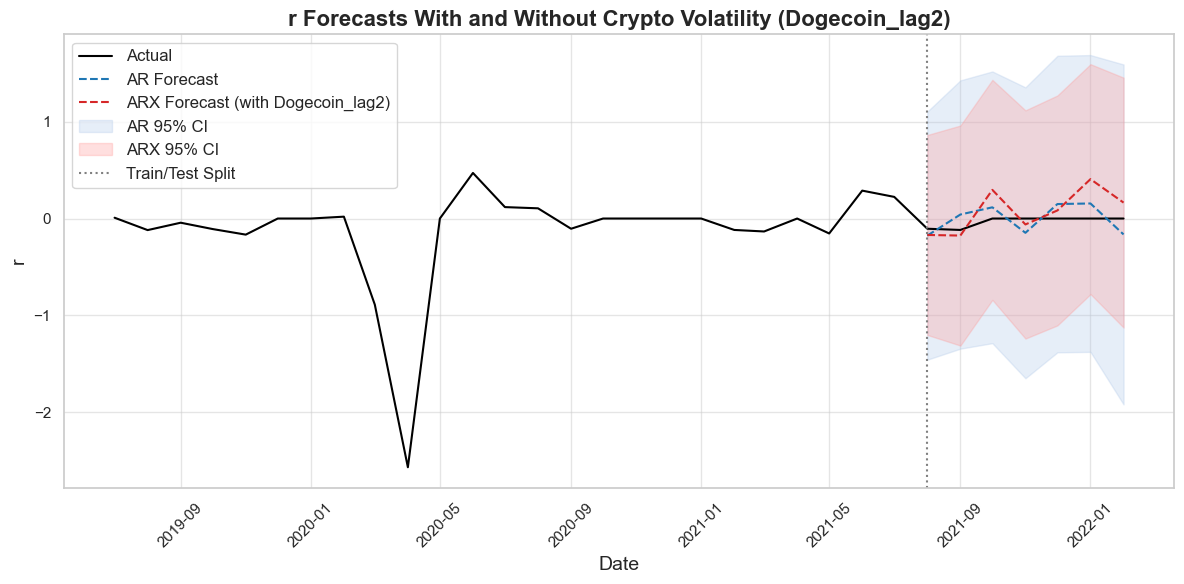

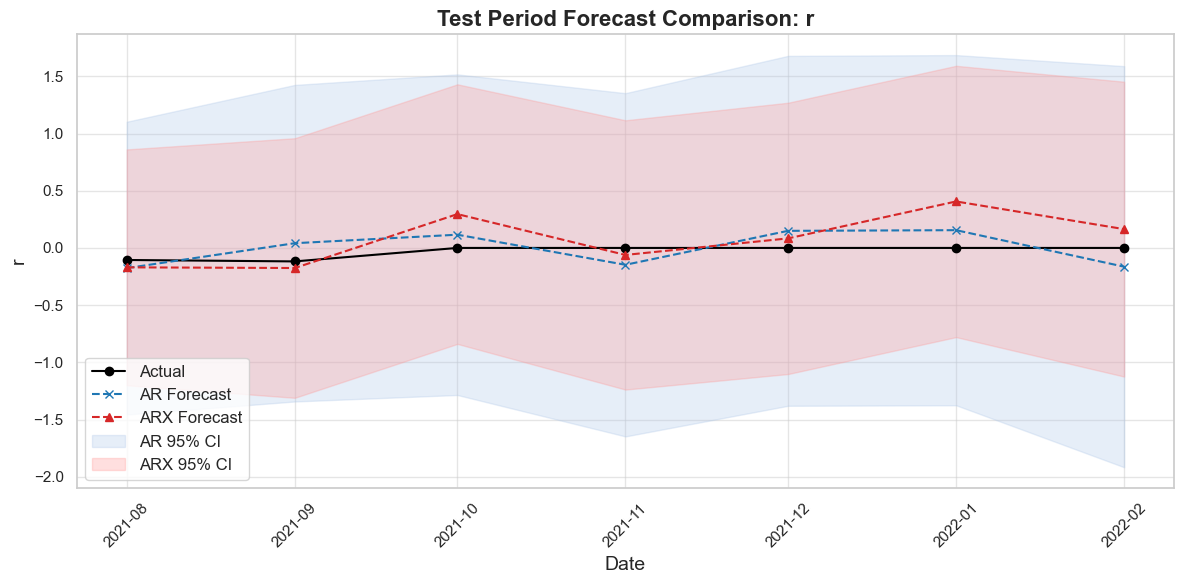

### Model Forecast Accuracy Metrics

,R2_train,MAE_test,RMSE_test,MAPE_test
AR,-0.259049,0.137379,0.140776,101.244442
ARX,0.164172,0.161825,0.206174,55.050306


### Model Assumption Check

,Breusch-Pagan p,Shapiro p,Anderson stat,Anderson crit,Mean resid,Durbin-Watson
AR,nan,0.010049,1.085443,"[(15.0, 0.508), (10.0, 0.579), (5.0, 0.694), (2.5, 0.81), (1.0, 0.963)]",0.020661,2.024776
ARX,0.001812,0.100419,0.556135,"[(15.0, 0.508), (10.0, 0.579), (5.0, 0.694), (2.5, 0.81), (1.0, 0.963)]",0.064152,2.061036


{'metrics_ar': {'R2_train': -0.2590489785637995,
  'MAE_test': 0.13737878531699316,
  'RMSE_test': 0.14077606970389103,
  'MAPE_test': 101.24444153697887},
 'metrics_arx': {'R2_train': 0.16417151228903804,
  'MAE_test': 0.16182468185945673,
  'RMSE_test': 0.20617392417480201,
  'MAPE_test': 55.050306412617324},
 'model_ar_order': (2, 0, 0),
 'model_ar_seasonal_order': (1, 1, 0, 3),
 'model_arx_order': (0, 0, 1),
 'model_arx_seasonal_order': (2, 1, 0, 3),
 'assumptions_ar': {'Breusch-Pagan p': nan,
  'Shapiro p': 0.01004854117878393,
  'Anderson stat': 1.0854430294534971,
  'Anderson crit': [(15.0, 0.508),
   (10.0, 0.579),
   (5.0, 0.694),
   (2.5, 0.81),
   (1.0, 0.963)],
  'Mean resid': 0.020660630145490837,
  'Durbin-Watson': 2.0247763194837156},
 'assumptions_arx': {'Breusch-Pagan p': 0.0018121710058285226,
  'Shapiro p': 0.10041911386116939,
  'Anderson stat': 0.5561350444686504,
  'Anderson crit': [(15.0, 0.508),
   (10.0, 0.579),
   (5.0, 0.694),
   (2.5, 0.81),
   (1.0, 0.963)]

In [ ]:
#df['r'] = np.log(df['r']).diff()
run_model('r', ['Dogecoin_lag2'], windows[0], diff=0, show = True)

In [161]:
def run_univariate_sarimax_screening(df_macro, df_exog, macro, window, diff, lag_prefix='Bitcoin', lag_range=7):
    """
    Screens exogenous variables one-by-one and returns their p-values from ARX model.
    """
    significance_results = []

    for i in range(lag_range):
        col = f"{lag_prefix}_lag{i}"
        if col not in df_exog.columns:
            print(f"[SKIPPED] {col} not in df_exog")
            continue

        try:
            result = run_model(macro, [col], window, diff, show = False)
            pval = result['exog_pvals'].get(col, None)
        except Exception as e:
            print(f"[ERROR] {col}: {e}")
            pval = None

        significance_results.append((col, pval))

    return pd.DataFrame(significance_results, columns=['Variable', 'P-Value']).sort_values(by='P-Value')


In [162]:
# asset_list= ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano','Tether', 'USD Coin']
# run_univariate_sarimax_screening(df, df_exog,'CC', windows[0], lag_prefix='Litecoin', lag_range=7)

In [163]:
def run_full_crypto_screening(df_macro, df_exog, macro, window, diff, lag_range=7, pval_threshold=0.05):
    asset_list = ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'Tether', 'USD Coin']
    final_results = []

    for asset in asset_list:
        # Get candidate exog variables passing p-value threshold (assumed)
        df_pvals = run_univariate_sarimax_screening(df_macro, df_exog, macro, window, diff, lag_prefix=asset, lag_range=lag_range)
        df_pvals = df_pvals[df_pvals['P-Value'] < pval_threshold]

        for _, row in df_pvals.iterrows():
            col = row['Variable']
            try:
                result = run_model(macro, [col], window, diff, show=False)

                baseline_mape = result['metrics_ar']['MAPE_test']
                new_mape = result['metrics_arx']['MAPE_test']

                improvement = (baseline_mape - new_mape) / baseline_mape * 100

                final_results.append({
                    'Variable': col,
                    'P-Value': row['P-Value'],
                    'Baseline MAPE': baseline_mape,
                    'New MAPE': new_mape,
                    'MAPE % Improvement': improvement
                })
            except Exception as e:
                print(f"[ERROR] Running model for {col}: {e}")
                continue

    df_final = pd.DataFrame(final_results)
    if not df_final.empty:
        df_final = df_final.sort_values(by='MAPE % Improvement', ascending=False)

    return df_final


In [164]:
macro = 'r'
df_results = run_full_crypto_screening(df, df_exog, macro, windows[0], diff = 0)

AR Order: (2, 0, 0) Seasonal: (1, 1, 0, 3)
ARX Order: (2, 0, 0) Seasonal: (0, 1, 0, 3)

=== AR Model Summary ===
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   25
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 3)   Log Likelihood                 -22.358
Date:                           Thu, 10 Jul 2025   AIC                             52.716
Time:                                   10:11:11   BIC                             57.080
Sample:                               07-01-2019   HQIC                            53.744
                                    - 07-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1    

KeyboardInterrupt: 

In [ ]:
print(df_results)

        Variable       P-Value  Baseline MAPE    New MAPE  MAPE % Improvement
6  Dogecoin_lag2  3.042787e-02     101.244442   55.050306           45.626342
5  Dogecoin_lag3  2.864379e-02     101.244442  179.037120          -76.836493
7   Cardano_lag0  3.419643e-02     101.244442  229.029315         -126.214212
0   Bitcoin_lag0  1.123158e-05     101.244442  370.376804         -265.824334
2       XRP_lag0  1.600733e-02     101.244442  475.291545         -369.449520
8  USD Coin_lag5  1.053565e-02     101.244442  492.883467         -386.825212
3  Ethereum_lag0  2.152368e-12     101.244442  573.125513         -466.080967
4  Ethereum_lag3  9.384645e-04     101.244442  624.705448         -517.026909
1  Litecoin_lag0  3.289116e-11     101.244442  966.799747         -854.916371


In [165]:
df_results.to_excel('r_w1.xlsx', index=False)